In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from sklearn import manifold

In [3]:
import torch
import sys
import os
import importlib
import torch
import numpy
import torch.nn.functional as F
from scipy.io import wavfile
from collections import defaultdict
import pickle
import random
# from asnorm import *

In [4]:
# make cohort set

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [6]:
sys.path.append('/workspace/GREAT_ASV_system/train_dist')

In [7]:
# from DatasetLoader import loadWAV

In [8]:
SpeakerNetModel = importlib.import_module('models.'+'EPACA-TDNN').__getattribute__('MainModel')

In [9]:
# EPACA-TDNN
S = SpeakerNetModel(n_mels=40, nOut=192, spec_aug=False)

EPACA-TDNN.py, Embedding size is 192, Channels 1024, Spec_aug False.


In [10]:
model_path = '/workspace/LOGS_OUTPUT/server9_nvme1/ASV_LOGS_202102/train_logs_201120/ECAPA-1024+BLDAT+(sdsv:)/model/model000000015.model'

In [11]:
# train_list = '/workspace/DATASET/server9_ssd/sdsv21/sdsv21_pretrain_10960.txt'
# train_list_FA = '/workspace/DATASET/server9_ssd/sdsv21/sdsv21_normal_FA1417.txt'
# train_list_EN = '/workspace/DATASET/server9_ssd/sdsv21/sdsv21_normal_EN9543.txt'
# train_path = '/workspace/DATASET/server9_ssd/sdsv21'
test_list = '/workspace/DATASET/server9_ssd/sdsv21/task2_testtriallist.txt'
enroll_list = '/workspace/DATASET/server9_ssd/sdsv21/sdsv20_enrolllist.txt'
test_path = '/workspace/DATASET/server9_ssd/sdsv21'
score_file = '/workspace/LOGS_OUTPUT/server9_nvme1/ASV_LOGS_202102/train_logs_201120/032900/result/eval_scores.txt'
result_path = '/workspace/LOGS_OUTPUT/server9_nvme1/ASV_LOGS_202102/train_logs_201120/032900/result'
out_path_1 = '/workspace/LOGS_OUTPUT/server9_nvme1/ASV_LOGS_202102/train_logs_201120/032900/result/eval_scores_as1.txt'

In [12]:
S.cuda()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(128, 128, kernel_size=(3,), 

In [13]:
loaded_state = torch.load(model_path, map_location="cuda:0")

In [14]:
# self_state = self.__model__.module.state_dict()
# loaded_state = torch.load(path, map_location="cuda:%d"%self.gpu)
# loaded_state = torch.load(path, map_location="cpu")
self_state = S.state_dict()

for name, param in loaded_state['model'].items():
    origname = name

    ## pass spk clf weight
    if '__L__' in name:
        print('pass __L__ classerfier W')
        continue

    ## pass DA weight
    if 'DA_module' in name:
        print('pass DA_module params:'+name)
        continue

    if name not in self_state:
        name = name.replace("__S__.", "")

        if name not in self_state:
            print("#%s is not in the model."%origname)
            continue

    if self_state[name].size() != loaded_state['model'][origname].size():
        print("#Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state['model'][origname].size()))
        continue

    self_state[name].copy_(param)

pass __L__ classerfier W
pass DA_module params:DA_module.backbone.torchfb.0.flipped_filter
pass DA_module params:DA_module.backbone.torchfb.1.spectrogram.window
pass DA_module params:DA_module.backbone.torchfb.1.mel_scale.fb
pass DA_module params:DA_module.backbone.layer1.conv.weight
pass DA_module params:DA_module.backbone.layer1.bn.weight
pass DA_module params:DA_module.backbone.layer1.bn.bias
pass DA_module params:DA_module.backbone.layer1.bn.running_mean
pass DA_module params:DA_module.backbone.layer1.bn.running_var
pass DA_module params:DA_module.backbone.layer1.bn.num_batches_tracked
pass DA_module params:DA_module.backbone.layer2.0.conv.weight
pass DA_module params:DA_module.backbone.layer2.0.bn.weight
pass DA_module params:DA_module.backbone.layer2.0.bn.bias
pass DA_module params:DA_module.backbone.layer2.0.bn.running_mean
pass DA_module params:DA_module.backbone.layer2.0.bn.running_var
pass DA_module params:DA_module.backbone.layer2.0.bn.num_batches_tracked
pass DA_module para

In [15]:
S.eval()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(128, 128, kernel_size=(3,), 

In [16]:
def loadWAV(filename, max_frames):

    # Maximum audio length
    max_audio = max_frames * 160 + 240

    # Read wav file and convert to torch tensor
    sample_rate, audio  = wavfile.read(filename)

    audiosize = audio.shape[0]

    if audiosize <= max_audio:
        shortage    = max_audio - audiosize + 1 
        audio       = numpy.pad(audio, (0, shortage), 'wrap')
        audiosize   = audio.shape[0]

    
    feats = []

    feats.append(audio)

    feat = numpy.stack(feats,axis=0).astype(numpy.float)

    return feat

In [17]:
loaded_state['model']['__L__.W'].size()

torch.Size([192, 10960])

In [18]:
W_matrix = loaded_state['model']['__L__.W']

In [19]:
W_matrix = W_matrix.t()

In [20]:
W_matrix.size()

torch.Size([10960, 192])

In [21]:
EN_list = [i for i in range(829, 10372)]
FA_list = [i for i in range(0, 829)] + [i for i in range(10372, 10960)]

In [22]:
cohort_FA_spk_dict_mean = {}
cohort_EN_spk_dict_mean = {}

In [23]:
for count, label_num in enumerate(FA_list):
    cohort_FA_spk_dict_mean[label_num] = F.normalize(W_matrix[label_num], p=2, dim=0).detach().cpu()
print(count)

1416


In [24]:
for count, label_num in enumerate(EN_list):
    cohort_EN_spk_dict_mean[label_num] = F.normalize(W_matrix[label_num], p=2, dim=0).detach().cpu()
print(count)

9542


In [25]:
cohort_FA_spk_dict_mean_nm = cohort_FA_spk_dict_mean
cohort_EN_spk_dict_mean_nm = cohort_EN_spk_dict_mean

In [26]:
1417 + 9543

10960

In [27]:
# plot embs

In [28]:
out_list = numpy.zeros([0, 192])
for i in cohort_FA_spk_dict_mean:
    out_list = numpy.append(out_list, cohort_FA_spk_dict_mean[i][None, :].detach().cpu().numpy(), axis=0)

out_list_2 = numpy.zeros([0, 192])
for i in cohort_EN_spk_dict_mean:
    out_list_2 = numpy.append(out_list_2, cohort_EN_spk_dict_mean[i][None, :].detach().cpu().numpy(), axis=0)


out_label = len(out_list)*[0] +2000*[1]
out_list_f = numpy.append(out_list, out_list_2[:2000], axis=0)

In [29]:
out_list_f.shape

(3417, 192)

In [30]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y = tsne.fit_transform(out_list_f)

Text(0.5, 1.0, 'protos')

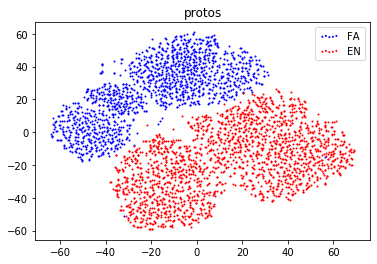

In [31]:
fig = plt.figure()
Y1 = Y[0:out_list.shape[0]]
out_label_1 = out_label[0:out_list.shape[0]]
Y2 = Y[out_list.shape[0]:]
out_label_2 = out_label[out_list.shape[0]:]
a = plt.scatter(Y1[:, 0], Y1[:, 1], color='b', s=1)
b = plt.scatter(Y2[:, 0], Y2[:, 1], color='r', s=1)
plt.legend([a, b],['FA', 'EN'], scatterpoints=5)
plt.title('protos')

In [32]:
# enroll sdsv21

In [33]:
enrollfilename = enroll_list
enroll_files = {}
## Read all enroll lines
with open(enrollfilename) as listfile:
    while True:
        line = listfile.readline()
        if (not line):
            break

        data = line.split();

        ## Enroll file should have line length >= 2
        assert len(data) >= 2

        enroll_files[data[0]] = data[1:]

In [34]:
len(enroll_files)

15555

In [35]:
enroll_dict = {}

In [36]:
for count, enroll_id in enumerate(enroll_files):
    for file in enroll_files[enroll_id]:
        wavline = file
        wavline = os.path.join(test_path, wavline)
        raw_inp = loadWAV(wavline, max_frames=0)
        raw_inp = torch.FloatTensor(raw_inp).cuda()

        ref_feat = S.forward(raw_inp).detach().cpu()

        if enroll_id not in enroll_dict.keys():
            enroll_dict[enroll_id] = ref_feat
        else:
            enroll_dict[enroll_id] = torch.cat([enroll_dict[enroll_id], ref_feat], axis=0)

    print(count+1, end='\r')


In [37]:
enroll_dict_nm = {}
for i in enroll_dict:
    enroll_dict_nm[i] = F.normalize(torch.mean(enroll_dict[i], dim=0).squeeze(0), p=2, dim=0)

In [38]:
len(enroll_dict_nm)

15555

In [39]:
# test sdsv21

In [40]:
listfilename = test_list
files = []
with open(listfilename) as listfile:
    while True:
        line = listfile.readline()
        if (not line):
            break

        data = line.split()

        if len(data) == 2: data = [random.randint(0,1)] + data

        files.append(data[2])

setfiles = list(set(files))
setfiles.sort()

In [41]:
len(setfiles)

69350

In [42]:
test_dict = {}

In [43]:
for count, line in enumerate(setfiles):
    wavline = line
    wavline = os.path.join(test_path, wavline)
    raw_inp = loadWAV(wavline, max_frames=0)
    raw_inp = torch.FloatTensor(raw_inp).cuda()
    
    ref_feat = S.forward(raw_inp).detach().cpu()

    test_dict[line] = ref_feat
    
    if ((count+1) % 1000) == 0:
        print((count+1)//1000, end='\r')

In [44]:
len(test_dict)

69350

In [45]:
test_dict_nm = {}
for i in test_dict:
    test_dict_nm[i] = F.normalize(test_dict[i].squeeze(0), p=2, dim=0)

In [46]:
### optional
# import pickle
# with open('tmp_chort_dict', 'wb') as f:
#     pickle.dump(cohort_spk_dict, f)
# import pickle
# with open('tmp_test_dict', 'wb') as f:
#     pickle.dump(test_dict, f)

In [47]:
15555 * 1417 // 100000

220

In [48]:
69542 * 1417 // 100000

985

In [49]:
count = 0
cohort2enroll = {}
for i in cohort_FA_spk_dict_mean_nm:
    cohort_emb = cohort_FA_spk_dict_mean_nm[i]
    for j in enroll_dict_nm:
        enroll_emb = enroll_dict_nm[j]
        score = F.cosine_similarity(cohort_emb, enroll_emb, dim=0).numpy().astype(numpy.float16)
        cohort2enroll[str(i)+" "+j] = score

        count += 1
        if (count % 100000) == 0:
            print(count // 100000, end='\r')
                
print(count)

22041435


In [50]:
count = 0
cohort2test = {}
for i in cohort_FA_spk_dict_mean_nm:
    cohort_emb = cohort_FA_spk_dict_mean_nm[i]
    for j in test_dict_nm:
        test_emb = test_dict_nm[j]
        score = F.cosine_similarity(cohort_emb, test_emb, dim=0).numpy().astype(numpy.float16)
        cohort2test[str(i)+" "+j] = score

        count += 1
        if (count % 100000) == 0:
            print(count // 100000, end='\r')
                
print(count)

98268950


In [51]:
len(cohort2test)

98268950

In [52]:
cohort2enroll_save_path = os.path.join(result_path, 'tmp_cohort2enroll.txt')
cohort2test_save_path = os.path.join(result_path, 'tmp_cohort2test.txt')

In [53]:
with open(cohort2enroll_save_path, 'w') as f:
    for count, i in enumerate(cohort2enroll):
        line = '%s %.4f\n'%(i, cohort2enroll[i])
        f.write(line)
        if (count % 100000) == 0:
            print(count // 100000, end='\r')

In [54]:
with open(cohort2test_save_path, 'w') as f:
    for count, i in enumerate(cohort2test):
        line = '%s %.4f\n'%(i, cohort2test[i])
        f.write(line)
        if (count % 100000) == 0:
            print(count // 100000, end='\r')

In [55]:
cohort2enroll = None
cohort2test = None

In [56]:
## optional
# import pickle
# with open('tmp_chort_dict', 'wb') as f:
#     pickle.dump(cohort2test, f)
# import pickle
# with open('tmp_test_dict', 'wb') as f:
#     pickle.dump(test_dict, f)

In [57]:
import torch
import sys
import os
import torch
import numpy
import torch.nn.functional as F
from scipy.io import wavfile
from collections import defaultdict

def as_norm_1(file_score_path, out_path, cohort2enroll_path, cohort2test_path, top_num=1000, hold_name=True, dict_sep=' '):
    # operation: norm_score = 0.5* ((score-mean_e_e)/str_e_e+(score-mean_t_t)/str_t_t)
    print('Score norm operation start, method: Adaptive_score_norm_type_1')
    print('')
    
    file_scores_as_norm_path = out_path
    enroll_dict = defaultdict(list)
    test_dict = defaultdict(list)

    with open(cohort2enroll_path, 'r') as f:
        for count, i in enumerate(f):
            cohort_utt, enroll_utt, score = i.strip().split(dict_sep)
            score = float(score)
            enroll_dict[enroll_utt].append([cohort_utt, score])
            if ((count+1) % 100000) == 0:
                print('read c2e:', (count+1)//100000, end='\r')
    
    with open(cohort2test_path, 'r') as f:
        for count, i in enumerate(f):
            cohort_utt, test_utt, score = i.strip().split(dict_sep)
            score = float(score)
            test_dict[test_utt].append([cohort_utt, score])
            if ((count+1) % 100000) == 0:
                print('read c2t:', (count+1)//100000, end='\r')
                
        
    mean_e_e = {}
    str_e_e = {}
    mean_t_t = {}
    str_t_t = {}
    
    print('')
    print('calculate enroll statistics')
    print('')
    
    for count, key in enumerate(enroll_dict):
        enroll_dict[key] = sorted(enroll_dict[key],key = lambda x:x[1], reverse = True)
        tmp_score_list = []
        for i in range(top_num):
            tmp_score_list.append(enroll_dict[key][i][1])
        mean_e_e[key] = numpy.mean(tmp_score_list)
        str_e_e[key] = numpy.std(tmp_score_list, ddof=1)
        if ((count+1) % 1000) == 0:
            print('cal e:', (count+1)//1000, end='\r')

    for count, key in enumerate(test_dict):
        test_dict[key] = sorted(test_dict[key],key = lambda x:x[1], reverse = True)
        tmp_score_list = []
        for i in range(top_num):
            tmp_score_list.append(test_dict[key][i][1])
        mean_t_t[key] = numpy.mean(tmp_score_list)
        str_t_t[key] = numpy.std(tmp_score_list, ddof=1)
        if ((count+1) % 1000) == 0:
            print('cal t:', (count+1)//1000, end='\r')

    print('')
    print('Scoring...')
    print('')
    
    file_scores = open(file_score_path)
    with open(file_scores_as_norm_path,'w') as f:
        for count, line in enumerate(file_scores):
            enroll_utt = line.split(' ')[1].strip()
            test_utt = line.split(' ')[2].strip()
            score = float(line.split(' ')[0].strip())
            norm_score = 0.5 * ((score-mean_e_e[enroll_utt])/str_e_e[enroll_utt]+(score-mean_t_t[test_utt])/str_t_t[test_utt])
            if hold_name:
                f.write('%.4f %s %s\n'%(norm_score, enroll_utt, test_utt))
            else:
                f.write('%.4f\n'%(norm_score))
            
            if ((count+1) % 10000) == 0:
                print((count+1)//10000, end='\r')
                
    file_scores.close()
    print('')
    print('Adaptive_score_norm_type_1 is finished')

In [58]:
as_norm_1(score_file, out_path_1, cohort2enroll_save_path, cohort2test_save_path, top_num=100, hold_name=True)

Score norm operation start, method: Adaptive_score_norm_type_1

read c2t: 982
calculate enroll statistics

cal t: 69
Scoring...

461
Adaptive_score_norm_type_1 is finished


In [59]:
# as_norm_2(score_file, out_path_2, cohort2test, cohort2test, top_num=1000, hold_name=True)

In [60]:
# get asnormed score_file & scoring